<a href="https://colab.research.google.com/github/kyle-gao/DDN/blob/main/DDN_Cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://github.com/GeoZcx/A-deeply-supervised-image-fusion-network-for-change-detection-in-remote-sensing-images

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import shutil
import os
from PIL import Image
import io

In [ ]:
def Conv2d_BN(x, nb_filter, kernel_size, strides=(1, 1), padding='same',droprate=0.1):
    x = tf.keras.layers.Conv2D(nb_filter, kernel_size, padding=padding, strides=strides,activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.Dropout(rate = droprate)(x)
    return x

def attach_attention_module(net, attention_module):
    if attention_module == 'se_block':  # SE_block
        net = se_block(net)
    elif attention_module == 'cbam_block':  # CBAM_block
        net = cbam_block(net)
    else:
        raise Exception("'{}' is not supported attention module!".format(attention_module))

    return net


def se_block(input_feature, ratio=8):
    """Contains the implementation of Squeeze-and-Excitation(SE) block.
    As described in https://arxiv.org/abs/1709.01507.
    """

    channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]

    se_feature = tf.keras.layers.GlobalAveragePooling2D()(input_feature)
    se_feature = tf.keras.layers.Reshape((1, 1, channel))(se_feature)
    assert se_feature.shape[1:] == (1, 1, channel)
    se_feature = tf.keras.layers.Dense(channel // ratio,
                       activation='relu',
                       kernel_initializer='he_normal',
                       use_bias=True,
                       bias_initializer='zeros')(se_feature)
    assert se_feature.shape[1:] == (1, 1, channel // ratio)
    se_feature = tf.keras.layers.Dense(channel,
                       activation='sigmoid',
                       kernel_initializer='he_normal',
                       use_bias=True,
                       bias_initializer='zeros')(se_feature)
    assert se_feature.shape[1:] == (1, 1, channel)
    if tf.keras.backend.image_data_format() == 'channels_first':
        se_feature = tf.keras.layers.Permute((3, 1, 2))(se_feature)

    se_feature = input_feature*se_feature
    return se_feature


def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block
    As described in https://arxiv.org/abs/1807.06521.
    """

    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature


def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]

    shared_layer_one = tf.keras.layers.Dense(channel // ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = tf.keras.layers.Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    avg_pool = tf.keras.layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = tf.keras.layers.Reshape((1, 1, channel))(avg_pool)
    assert avg_pool.shape[1:] == (1, 1, channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool.shape[1:] == (1, 1, channel // ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool.shape[1:] == (1, 1, channel)

    max_pool = tf.keras.layers.GlobalMaxPooling2D()(input_feature)
    max_pool = tf.keras.layers.Reshape((1, 1, channel))(max_pool)
    assert max_pool.shape[1:] == (1, 1, channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool.shape[1:] == (1, 1, channel // ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool.shape[1:] == (1, 1, channel)

    cbam_feature = avg_pool + max_pool
    cbam_feature = tf.keras.layers.Activation('sigmoid')(cbam_feature)

    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = tf.keras.layers.Permute((3, 1, 2))(cbam_feature)

    return input_feature * cbam_feature


def spatial_attention(input_feature):
    kernel_size = 7

    if tf.keras.backend.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = tf.keras.layers.Permute((2, 3, 1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = tf.keras.layers.Conv2D(filters=1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = tf.keras.layers.Permute((3, 1, 2))(cbam_feature)

    return input_feature * cbam_feature


def get_spatial_attention_map(input_feature):
    kernel_size = 7
    cbam_feature = input_feature

    avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = tf.keras.layers.Conv2D(filters=1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = tf.keras.layers.Permute((3, 1, 2))(cbam_feature)

    return cbam_feature

#Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if not(os.path.isdir("/content/Kaggle_CoverChange")):
  shutil.unpack_archive("/content/drive/MyDrive/Kaggle_CoverChange.zip","/content/")

In [ ]:
data_dir = "/content/Kaggle_CoverChange"

#dataset is made up of strings
oh_label = True
out_list = True
out_layers = 5
concat_and_mask = True
base_vgg = True

In [ ]:

#classes = array([ 29.,  38.,  75.,  76., 128., 150., 255.])
class_dict = {(29):1, (38):2, (75):3,(76):3,128:4,150:5,(255):0} #mapping 75 and 76 to same class, i'm assuming this is an encoding issue.

def to_categorical(tensor,class_dict):
  #maps pixel values to categories 1,2...num_classes
  for k,v in class_dict.items():
    tensor[tensor==k]=v
  return tensor

In [ ]:
label1_fn = "/content/Kaggle_CoverChange/label1/00003.png"
label1 = tf.keras.preprocessing.image.load_img(label1_fn,color_mode="grayscale")
label1 = tf.keras.preprocessing.image.img_to_array(label1)

##Testing label change conversion

In [ ]:
num_classes = 6

##Need to convert 2 labels into 1 change label

Trick: Let n be number of classes
Step 1. Use an outer product between one_hot encoded labels
(h,w,n),(h,w,n)->(h,w,n,n), this is gives a one hot encoded change matrix M.

Eg. M = 0 except for Mij = 1 -> class i changed to class j.

Step 2. Convert to categorical change -> (h,w,n,n)->(h,w,n^2)

In [ ]:
"""#converting (label1,label2)->(label changemap)
#where change map has num_classes^2 (not all unique) change classes 
def make_label_change_dict(num_classes):
  label_change_dict = {}
  i = 0
  for x in range(num_classes):
    for y in range(num_classes):
      label_change_dict[(x,y)] = i *(x!=y)
      i += 1
  return label_change_dict

label_change_dict = make_label_change_dict(6)
print(label_change_dict)"""

#converting (label1,label2)->(label changemap)
#where change map has num_classes^2 (not all unique) change classes 
def make_label_change_array(num_classes):
  """Arg:
  num_classes:int, number of classes
  returns:
  num_classes^2 matrix of categorical change labels.
  """
  label_change_arr = np.zeros((num_classes,num_classes),dtype=np.uint8)
  i = 0
  for x in range(num_classes):
    for y in range(num_classes):
      label_change_arr[x,y] = i *(x!=y)
      i += 1
  return label_change_arr

label_change_arr = make_label_change_array(6)

print(label_change_arr)

[[ 0  1  2  3  4  5]
 [ 6  0  8  9 10 11]
 [12 13  0 15 16 17]
 [18 19 20  0 22 23]
 [24 25 26 27  0 29]
 [30 31 32 33 34  0]]


In [ ]:
def get_class_change_label(before,after,label_change_arr):
  """
  Input:
  two np.array or tf.tensor of shape (batch,Width,Height, num_classes) corresponding to class labeled data in one hot encoding
  the arrays represent the before and after class labels for change detection
  Output:
  a np.array of shape (batch,Width,Height) corresponding to change labels (see figure 2)
  """
  labels_combined = np.einsum("abd,abe->abde",before,after)
  labels_combined = labels_combined*label_change_arr
  labels_combined = np.sum(labels_combined, axis=(-1,-2))
  return labels_combined

In [ ]:
label1_fn = "/content/Kaggle_CoverChange/label1/00018.png"
label2_fn = "/content/Kaggle_CoverChange/label2/00018.png"

##Data processing

*   Load as string dataset of filenames
*   map get_item() to create dataset of (image1,image2, change labels)
*   apply other pipeline steps (batching, shuffling, transformations)
 

Tricks:

Creating 1 change map from 2 labels:


*   one hot encode the labels
*   use an outer produce to produce a one-hot change matrix
*   flatten for one hot change matrix, or use broadcast a change_array see make_label_change_array
*   convert to categorical as needed

Creating 2 change maps from 2 change labels:


*   one hot encode labels
*   substract label 2 from label 1, l3 = l1-l2
*   l3 == 1 correspond to elements removed from label 1
*   l3 == -1 correspond to elements added by label 2







In [ ]:
def get_item(path):
  """
  returns 3 tensors when called in a dataset.map
  """

  #wrap function in tf.numpy_function() or tf.data.dataset.map bugs out

  def _get_item(path):
    """
    args:
    path: Dataset.list_file dataset element

    returns: 
    (h,w,3),(h,w,1),(h,w,3),(h,w,1) image-label 4-tuple in tf.float32 tf.Tensor
    """

    fn = tf.strings.split(path,"/")
    base_dir = tf.strings.join(fn[:-2],separator="/")

    image1_fn = (base_dir+"/im1/"+fn[-1]).numpy()
    image2_fn = (base_dir+"/im2/"+fn[-1]).numpy()

    label1_fn = (base_dir+"/label1/"+fn[-1]).numpy()
    label2_fn = (base_dir+"/label2/"+fn[-1]).numpy()

    #label1_fn = "/content/Kaggle_CoverChange/label1/00018.png"
    #label2_fn = "/content/Kaggle_CoverChange/label2/00018.png"


    image1 = tf.keras.preprocessing.image.load_img(image1_fn)
    image1 = tf.keras.preprocessing.image.img_to_array(image1)

    image2 = tf.keras.preprocessing.image.load_img(image2_fn)
    image2 = tf.keras.preprocessing.image.img_to_array(image2)

    label1 = tf.keras.preprocessing.image.load_img(label1_fn, color_mode="grayscale")
    label1 = tf.keras.preprocessing.image.img_to_array(label1)
    label1 = to_categorical(label1,class_dict)
    #label1 = tf.expand_dims(label1,axis=0)

    label1 = tf.one_hot(tf.cast(label1[:,:,0],dtype = tf.uint8),depth = num_classes)




    label2 = tf.keras.preprocessing.image.load_img(label2_fn, color_mode ="grayscale")
    label2 = tf.keras.preprocessing.image.img_to_array(label2)
    label2 = to_categorical(label2,class_dict)
    #label2 = tf.expand_dims(label2,axis=0)

    label2 = tf.one_hot(tf.cast(label2[:,:,0],dtype = tf.uint8),depth=num_classes)

    #change_label = get_class_change_label(label1,label2,label_change_arr=label_change_arr)
    label1,label2 = two_labels_to_twochanges(label1,label2) #(1,H,W,num_classes)
    
    
    if oh_label:
      change_label = tf.one_hot(tf.cast(change_label[:,:],dtype = tf.uint8),depth=num_classes**2-1)
    else:
      change_label = tf.expand_dims(change_label, axis=-1)
    """
    #doesn't work, errors on backend when passing datasets from list of tensors of different size
    if out_list:
      y_list = [change_label]
      change_label = tf.expand_dims(change_label,axis=0)
      for i in range(out_layers):
        
        change_label = tf.keras.layers.MaxPool2D()(change_label)
        y_list.append(change_label.numpy()[0,:,:,:])
      change_label = tf.ragged.constant(y_list)
    """

    #classes = array([ 29.,  38.,  75.,  76., 128., 150., 255.])
    #(h,w,1) tensor of int from 1-6
    

    return image1,image2,change_label

  output = tf.numpy_function(_get_item,[path],[tf.float32,tf.float32,tf.float32])

  return output

In [ ]:
def two_labels_to_twochanges(l1,l2):
  """
  args:
  l1,l2 one_hot encoded labels
  returns: l3, l4, mask: one_hot encoded labels of changes and change mask
  eg (categorical version) : if at a pixel p :
   l1 == 1, l2 == 1 => l3 = 0, l4 = 0
   but instead
   l1 == 1, l2 == 2 => l3 = 1, l4 = 2
  """
  lmixed = l1 - l2
  l3 = lmixed == 1 
  l4 = lmixed == -1
  mask = lmixed != 0
  return l3, l4

def get_item2(path):
  """
  returns 4 tensors: image1,image2, (label1,label2), change mask
  when called inside a dataset.map
  """

  #wrap function in tf.numpy_function() or tf.data.dataset.map bugs out

  def _get_item2(path):
    """
    args:
    path: Dataset.list_file dataset element

    returns: 
    (h,w,3),(h,w,1),(h,w,3),(h,w,1) image-label 4-tuple in tf.float32 tf.Tensor
    """

    fn = tf.strings.split(path,"/")
    base_dir = tf.strings.join(fn[:-2],separator="/")

    image1_fn = (base_dir+"/im1/"+fn[-1]).numpy()
    image2_fn = (base_dir+"/im2/"+fn[-1]).numpy()

    label1_fn = (base_dir+"/label1/"+fn[-1]).numpy()
    label2_fn = (base_dir+"/label2/"+fn[-1]).numpy()

    #label1_fn = "/content/Kaggle_CoverChange/label1/00018.png"
    #label2_fn = "/content/Kaggle_CoverChange/label2/00018.png"


    image1 = tf.keras.preprocessing.image.load_img(image1_fn)
    image1 = tf.keras.preprocessing.image.img_to_array(image1)

    image2 = tf.keras.preprocessing.image.load_img(image2_fn)
    image2 = tf.keras.preprocessing.image.img_to_array(image2)

    label1 = tf.keras.preprocessing.image.load_img(label1_fn, color_mode="grayscale")
    label1 = tf.keras.preprocessing.image.img_to_array(label1)
    label1 = to_categorical(label1,class_dict)
    #label1 = tf.expand_dims(label1,axis=0)
    label1 = tf.one_hot(tf.cast(label1[:,:,0],dtype = tf.uint8),depth = num_classes)


    label2 = tf.keras.preprocessing.image.load_img(label2_fn, color_mode ="grayscale")
    label2 = tf.keras.preprocessing.image.img_to_array(label2)
    label2 = to_categorical(label2,class_dict)
    #label2 = tf.expand_dims(label2,axis=0)
    label2 = tf.one_hot(tf.cast(label2[:,:,0],dtype = tf.uint8),depth=num_classes)

    label1,label2 = two_labels_to_twochanges(label1,label2) #(1,H,W,num_classes)
    

    if not(oh_label):
      #label1 = tf.argmax(label1, axis=-1,output_type=tf.float32)
      label1 = tf.expand_dims(label1,axis=-1)
      #label2 = tf.argmax(label2, axis=-1,output_type=tf.float32)
      label2 = tf.expand_dims(label2,axis=-1)

    change_label = tf.concat([label1,label2],axis=-1) #(1,512,512, 2*num_class) if one_hot, (1,512,512,2) otherwise
    change_label = tf.cast(change_label,tf.float32)
    change_mask = change_label.numpy() != 0
    change_mask = tf.cast(change_mask,tf.float32)
    change_mask = tf.math.reduce_sum(change_mask,axis=-1)

      
    """
    #doesn't work, errors on backend when passing datasets from list of tensors of different size
    if out_list:
      y_list = [change_label]
      change_label = tf.expand_dims(change_label,axis=0)
      for i in range(out_layers):
        
        change_label = tf.keras.layers.MaxPool2D()(change_label)
        y_list.append(change_label.numpy()[0,:,:,:])
      change_label = tf.ragged.constant(y_list)
    """

    #classes = array([ 29.,  38.,  75.,  76., 128., 150., 255.])
    #(h,w,1) tensor of int from 1-6
    

    return image1,image2,change_label,change_mask

  output = tf.numpy_function(_get_item2,[path],[tf.float32,tf.float32,tf.float32,tf.float32])

  return output

In [ ]:
def transform(x1,x2,y):
  """
  Write your data transformations here
  """
  x1=tf.keras.layers.experimental.preprocessing.Rescaling(1./255.0)(x1)
  x2=tf.keras.layers.experimental.preprocessing.Rescaling(1./255.0)(x2)
  #y=tf.one_hot(tf.cast(y[:,:,0],dtype = tf.int32),depth = 7)
  """
  if out_list:
    y_list = [y]
    for i in range(out_layers):
      y = tf.keras.layers.MaxPool2D()(y)
      y_list.append(y)
    y = tf.ragged.constant(y_list)
    """
    

  return x1,x2,y

def transform2(x1,x2,y1,y2):
  """
  Write your data transformations here
  """
  x1=tf.keras.layers.experimental.preprocessing.Rescaling(1./255.0)(x1)
  x2=tf.keras.layers.experimental.preprocessing.Rescaling(1./255.0)(x2)
  #y=tf.one_hot(tf.cast(y[:,:,0],dtype = tf.int32),depth = 7)
  """
  if out_list:
    y_list = [y]
    for i in range(out_layers):
      y = tf.keras.layers.MaxPool2D()(y)
      y_list.append(y)
    y = tf.ragged.constant(y_list)
    """
    

  return x1,x2,y1,y2

def preprocessing(list_ds,batch_size=8,augmentation=transform):
  """
  applies some preprocessing
  args:
  list_ds-Dataset.list_files dataset object
  batch_size-int 
  augmentation-a function (x,y)->(x,y)
  returns-batched dataset
  """

  #ds = list_ds.cache() 
  if concat_and_mask:
    ds = list_ds.map(get_item2,num_parallel_calls=tf.data.AUTOTUNE) 
    ds = ds.batch(batch_size,drop_remainder=True)
    ds = ds.shuffle(100)

    if augmentation:
      ds = ds.map((lambda x1,x2,y1,y2 : augmentation(x1,x2,y1,y2)),num_parallel_calls=tf.data.AUTOTUNE)
      
  else:
    ds = list_ds.map(get_item,num_parallel_calls=tf.data.AUTOTUNE) 
    ds = ds.batch(batch_size,drop_remainder=True)
    ds = ds.shuffle(100)
    if augmentation:
      ds = ds.map((lambda x,y,z : augmentation(x,y,z)),num_parallel_calls=tf.data.AUTOTUNE)
      


  
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds



#load pretrained model

##Test

In [ ]:
"""
vgg16_512 = tf.keras.models.load_model("/content/Drive/Saved_Model")
vgg16_512.summary()

feature_layers = [vgg16_512.get_layer("features_c1"),vgg16_512.get_layer("features_c2"),vgg16_512.get_layer('features_c3'),vgg16_512.get_layer('features_c4'),vgg16_512.get_layer('features_c5')]
feature_extractor = tf.keras.models.Model(inputs = vgg16_512.input, outputs = [layer.output for layer in feature_layers])

test_tensor = tf.random.normal((1,512,512,3))
test_out = feature_extractor(test_tensor)
for t in test_out:
  print(t.shape)
"""

'\nvgg16_512 = tf.keras.models.load_model("/content/Drive/Saved_Model")\nvgg16_512.summary()\n\nfeature_layers = [vgg16_512.get_layer("features_c1"),vgg16_512.get_layer("features_c2"),vgg16_512.get_layer(\'features_c3\'),vgg16_512.get_layer(\'features_c4\'),vgg16_512.get_layer(\'features_c5\')]\nfeature_extractor = tf.keras.models.Model(inputs = vgg16_512.input, outputs = [layer.output for layer in feature_layers])\n\ntest_tensor = tf.random.normal((1,512,512,3))\ntest_out = feature_extractor(test_tensor)\nfor t in test_out:\n  print(t.shape)\n'

#DDN

In [ ]:
#vgg16_512 = tf.keras.models.load_model("/content/Drive/Saved_Model")
#vgg16_512.summary()

In [ ]:
def masked_difference_network (imsize, out_dims = 35, final_activation = "softmax"):
    #if input image 512*512

    

    image1 = tf.keras.layers.Input((imsize,imsize,3),name = "image1")
    image2 = tf.keras.layers.Input((imsize,imsize,3),name = "image2")
    mask512 = tf.keras.layers.Input((imsize,imsize,1),name = "diff_mask")
    if base_vgg:
      vgg16_512 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(512,512,3))
      feature_layers = [vgg16_512.get_layer('block1_conv2'),vgg16_512.get_layer('block2_conv2'),vgg16_512.get_layer('block3_conv3'),vgg16_512.get_layer('block4_conv3'),vgg16_512.get_layer('block5_conv3')]
      feature_extractor = tf.keras.models.Model(inputs = vgg16_512.input, outputs = [layer.output for layer in feature_layers],trainable=True)

    else:
      if not(os.path.isdir("/content/Drive/Saved_Model/")):
        shutil.unpack_archive("/content/drive/MyDrive/vgg_512_seg_model.zip","/content/Drive/Saved_Model/")
      vgg16_512 = tf.keras.models.load_model("/content/Drive/Saved_Model")
      feature_layers = [vgg16_512.get_layer("features_c1"),vgg16_512.get_layer("features_c2"),vgg16_512.get_layer('features_c3'),vgg16_512.get_layer('features_c4'),vgg16_512.get_layer('features_c5')]
      feature_extractor = tf.keras.models.Model(inputs = vgg16_512.input, outputs = [layer.output for layer in feature_layers],trainable=True)

    features_1 = feature_extractor(image1)
    features_2 = feature_extractor(image2)

    t1_b5c3 = features_1[4] #(None, 32, 32, 512)
    t2_b5c3 = features_2[4] 

    t1_b4c3 = features_1[3] #(None, 64, 64, 512)
    t2_b4c3 = features_2[3] 
    
    t1_b3c3 = features_1[2] #(None, 128, 128, 256)  
    t2_b3c3 = features_2[2]

    t1_b2c2 = features_1[1]
    t2_b2c2 = features_2[1] #(None, 256, 256, 128) 

    t1_b1c2 = features_1[0]
    t2_b1c2 = features_2[0] #(None, 512, 512, 64)

    mask256 = tf.keras.layers.MaxPool2D()(mask512)
    mask128 = tf.keras.layers.MaxPool2D()(mask256)
    mask64 = tf.keras.layers.MaxPool2D()(mask128)
    mask32 = tf.keras.layers.MaxPool2D()(mask64)

    """
    pair5 = tf.keras.layers.Input((imsize,imsize,64*2), name='pair5') #rbg images concatenated channel-wise
    pair4 = tf.keras.layers.Input((imsize//2,imsize//2,128*2), name='pair4')
    pair3 = tf.keras.layers.Input((imsize//4,imsize//4,256*2), name='pair3')
    pair2 = tf.keras.layers.Input((imsize//8,imsize//8,512*2), name='pair2')
    pair1 = tf.keras.layers.Input((imsize//16,imsize//16,512*2), name='pair1')


    t1_b5c3 = pair1[:,:,:,:3] #(None, 32, 32, 512)
    t2_b5c3 = pair1[:,:,:,3:] 

    t1_b4c3 = pair2[:,:,:,:3] #(None, 64, 64, 512)
    t2_b4c3 = pair2[:,:,:,3:] 
    
    t1_b3c3 = pair3[:,:,:,:3] #(None, 128, 128, 256)  
    t2_b3c3 = pair3[:,:,:,3:]

    t1_b2c2 = pair4[:,:,:,:3]
    t2_b2c2 = pair4[:,:,:,3:] #(None, 256, 256, 128) 

    t1_b1c2 = pair5[:,:,:,:3]
    t2_b1c2 = pair5[:,:,:,3:] #(None, 512, 512, 64)
    """

    concat_b5c3 = tf.keras.layers.concatenate([t1_b5c3, t2_b5c3,mask32], axis=3) #channel 1024
    x = Conv2d_BN(concat_b5c3,512, 3)
    x = Conv2d_BN(x,512,3)
    #attention_map_1 = get_spatial_attention_map(x)
    #x = x * attention_map_1
    x = tf.keras.layers.BatchNormalization(axis=3)(x)

    #branch1
    branch_1 =Conv2d_BN(x,64,3)
    branch_1 =tf.keras.layers.Conv2D(out_dims, kernel_size=3, padding='same',name='output_32',activation=final_activation)(branch_1)

    x = tf.keras.layers.Conv2DTranspose(imsize, kernel_size=5, strides=2, kernel_initializer="he_normal", padding='same', activation = 'relu')(x)
    x = tf.keras.layers.concatenate([x,t1_b4c3,t2_b4c3,mask64],axis=3)
    x = channel_attention(x)
    x = Conv2d_BN(x,256,3)
    x = Conv2d_BN(x,256,3)
    x = Conv2d_BN(x,256,3)
    #attention_map_2 = get_spatial_attention_map(x)
    #x = x *attention_map_2
    x = tf.keras.layers.BatchNormalization(axis=3)(x)

    #branch2
    branch_2 =Conv2d_BN(x,64,3)
    branch_2 =tf.keras.layers.Conv2D(out_dims, kernel_size=3, padding='same',name='output_64',activation=final_activation)(branch_2)

    x = tf.keras.layers.Conv2DTranspose(256, kernel_size=5, strides=2, kernel_initializer="he_normal", padding='same',activation = 'relu')(x)
    x = tf.keras.layers.concatenate([x,t1_b3c3,t2_b3c3,mask128],axis=3)
    #x = tf.keras.layers.concatenate([x,t1_b3c3,t2_b3c3],axis=3)
    x = channel_attention(x)
    x = Conv2d_BN(x,128,3)
    x = Conv2d_BN(x,128,3)
    x = Conv2d_BN(x, 128, 3)
    #attention_map_3 = get_spatial_attention_map(x)
    #x = x * attention_map_3
    x = tf.keras.layers.BatchNormalization(axis=3)(x)

    #branch3
    branch_3 =Conv2d_BN(x,64,3)
    branch_3 =tf.keras.layers.Conv2D(out_dims, kernel_size=3, padding='same',name='output_128',activation=final_activation)(branch_3)

    x = tf.keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, kernel_initializer="he_normal", padding='same',activation = 'relu')(x)
    x = tf.keras.layers.concatenate([x,t1_b2c2,t2_b2c2,mask256],axis=3)
    #x = tf.keras.layers.concatenate([x,t1_b2c2,t2_b2c2],axis=3)
    x = channel_attention(x)
    x = Conv2d_BN(x,128,3)
    x = Conv2d_BN(x,64,3)
    x = Conv2d_BN(x, 64, 3)
    #attention_map_4 = get_spatial_attention_map(x)
    #x = x * attention_map_4
    x = tf.keras.layers.BatchNormalization(axis=3)(x)

    #branch4
    branch_4 =Conv2d_BN(x,64,3)
    branch_4 =tf.keras.layers.Conv2D(out_dims, kernel_size=3, padding='same',name='output_256',activation=final_activation)(branch_4)

    x = tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, kernel_initializer="he_normal", padding='same',activation = 'relu')(x)
    x = tf.keras.layers.concatenate([x,t1_b1c2,t2_b1c2],axis=3)
    #x = tf.keras.layers.concatenate([x,t1_b1c2,t2_b1c2,mask512],axis=3)
    x = channel_attention(x)
    x = Conv2d_BN(x,64,3)
    x = Conv2d_BN(x,64,3) 
    x = Conv2d_BN(x, 32, 3)
    attention_map_5 = get_spatial_attention_map(x)
    x = x * attention_map_5

    # branch5
    branch_5 =Conv2d_BN(x,32,3)
    branch_5 =tf.keras.layers.Conv2D(out_dims, kernel_size=3, padding='same',name='output_imsize',activation=final_activation)(branch_5)

    model = tf.keras.models.Model(inputs=[image1,image2,mask512], outputs=[branch_5,branch_4,branch_3,branch_2,branch_1])

    return model

In [ ]:
#@title DDN tf.keras
def DDN (imsize, out_dims = 35):
    #if input image 512*512

    vgg16_512 = tf.keras.models.load_model("/content/Drive/Saved_Model")

    image1 = tf.keras.layers.Input((imsize,imsize,3),name = "image1")
    image2 = tf.keras.layers.Input((imsize,imsize,3),name = "image2")

    feature_layers = [vgg16_512.get_layer("features_c1"),vgg16_512.get_layer("features_c2"),vgg16_512.get_layer('features_c3'),vgg16_512.get_layer('features_c4'),vgg16_512.get_layer('features_c5')]
    feature_extractor = tf.keras.models.Model(inputs = vgg16_512.input, outputs = [layer.output for layer in feature_layers],trainable=True)

    features_1 = feature_extractor(image1)
    features_2 = feature_extractor(image2)

    t1_b5c3 = features_1[4] #(None, 32, 32, 512)
    t2_b5c3 = features_2[4] 

    t1_b4c3 = features_1[3] #(None, 64, 64, 512)
    t2_b4c3 = features_2[3] 
    
    t1_b3c3 = features_1[2] #(None, 128, 128, 256)  
    t2_b3c3 = features_2[2]

    t1_b2c2 = features_1[1]
    t2_b2c2 = features_2[1] #(None, 256, 256, 128) 

    t1_b1c2 = features_1[0]
    t2_b1c2 = features_2[0] #(None, 512, 512, 64)
    



    """
    pair5 = tf.keras.layers.Input((imsize,imsize,64*2), name='pair5') #rbg images concatenated channel-wise
    pair4 = tf.keras.layers.Input((imsize//2,imsize//2,128*2), name='pair4')
    pair3 = tf.keras.layers.Input((imsize//4,imsize//4,256*2), name='pair3')
    pair2 = tf.keras.layers.Input((imsize//8,imsize//8,512*2), name='pair2')
    pair1 = tf.keras.layers.Input((imsize//16,imsize//16,512*2), name='pair1')


    t1_b5c3 = pair1[:,:,:,:3] #(None, 32, 32, 512)
    t2_b5c3 = pair1[:,:,:,3:] 

    t1_b4c3 = pair2[:,:,:,:3] #(None, 64, 64, 512)
    t2_b4c3 = pair2[:,:,:,3:] 
    
    t1_b3c3 = pair3[:,:,:,:3] #(None, 128, 128, 256)  
    t2_b3c3 = pair3[:,:,:,3:]

    t1_b2c2 = pair4[:,:,:,:3]
    t2_b2c2 = pair4[:,:,:,3:] #(None, 256, 256, 128) 

    t1_b1c2 = pair5[:,:,:,:3]
    t2_b1c2 = pair5[:,:,:,3:] #(None, 512, 512, 64)
    """

    concat_b5c3 = tf.keras.layers.concatenate([t1_b5c3, t2_b5c3], axis=3) #channel 1024
    x = Conv2d_BN(concat_b5c3,256, 3)
    x = Conv2d_BN(x,128,3)
    attention_map_1 = get_spatial_attention_map(x)
    x = x * attention_map_1
    x = tf.keras.layers.BatchNormalization(axis=3)(x)

    #branche1
    branch_1 =tf.keras.layers.Conv2D(out_dims, kernel_size=3, padding='same',name='output_32')(x)

    x = tf.keras.layers.Conv2DTranspose(imsize, kernel_size=5, strides=2, kernel_initializer="he_normal", padding='same')(x)
    x = tf.keras.layers.concatenate([x,t1_b4c3,t2_b4c3],axis=3)
    x = channel_attention(x)
    x = Conv2d_BN(x,256,3)
    x = Conv2d_BN(x,128,3)
    x = Conv2d_BN(x,64,3)
    attention_map_2 = get_spatial_attention_map(x)
    x = x *attention_map_2
    x = tf.keras.layers.BatchNormalization(axis=3)(x)

    #branche2
    branch_2 =tf.keras.layers.Conv2D(out_dims, kernel_size=3, padding='same',name='output_64')(x)

    x = tf.keras.layers.Conv2DTranspose(256, kernel_size=5, strides=2, kernel_initializer="he_normal", padding='same')(x)
    x = tf.keras.layers.concatenate([x,t1_b3c3,t2_b3c3],axis=3)
    x = channel_attention(x)
    x = Conv2d_BN(x,256,3)
    x = Conv2d_BN(x,128,3)
    x = Conv2d_BN(x, 64, 3)
    attention_map_3 = get_spatial_attention_map(x)
    x = x * attention_map_3
    x = tf.keras.layers.BatchNormalization(axis=3)(x)

    #branche3
    branch_3 =tf.keras.layers.Conv2D(out_dims, kernel_size=3, padding='same',name='output_128')(x)

    x = tf.keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, kernel_initializer="he_normal", padding='same')(x)
    x = tf.keras.layers.concatenate([x,t1_b2c2,t2_b2c2],axis=3)
    x = channel_attention(x)
    x = Conv2d_BN(x,128,3)
    x = Conv2d_BN(x,64,3)
    x = Conv2d_BN(x, 64, 3)
    attention_map_4 = get_spatial_attention_map(x)
    x = x * attention_map_4
    x = tf.keras.layers.BatchNormalization(axis=3)(x)

    #branche4
    branch_4 =tf.keras.layers.Conv2D(out_dims, kernel_size=3, padding='same',name='output_256')(x)

    x = tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, kernel_initializer="he_normal", padding='same')(x)
    x = tf.keras.layers.concatenate([x,t1_b1c2,t2_b1c2],axis=3)
    x = channel_attention(x)
    x = Conv2d_BN(x,64,3)
    x = Conv2d_BN(x,64,3) 
    x = Conv2d_BN(x, 32, 3)
    attention_map_5 = get_spatial_attention_map(x)
    x = x * attention_map_5

    # branche5
    branch_5 =tf.keras.layers.Conv2D(out_dims, kernel_size=3, padding='same',name='output_imsize')(x)

    DDN = tf.keras.models.Model(inputs=[image1,image2], outputs=[branch_5,branch_4,branch_3,branch_2,branch_1])

    return DDN

In [ ]:
#TEST
"""
imsize = 512
image1 = tf.random.normal((1,512,512,3))
image2 = tf.random.normal((1,512,512,3))
ddn = DDN(512,6)
forward = ddn([image1,image2])
for f in forward:
  print (f.shape)"""

'\nimsize = 512\nimage1 = tf.random.normal((1,512,512,3))\nimage2 = tf.random.normal((1,512,512,3))\nddn = DDN(512,6)\nforward = ddn([image1,image2])\nfor f in forward:\n  print (f.shape)'

In [ ]:
ddn = masked_difference_network(512,out_dims = 12)
ddn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
diff_mask (InputLayer)          [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 1)  0           diff_mask[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 1)  0           max_pooling2d[0][0]              
__________________________________________________________________________________________________
image1 (InputLayer)             [(None, 512, 512, 3) 0                                            
____________________________________________________________________________________________

#Defining loss and metrics
Using Pooling layers to reduce target image size for deep supervision

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, warmup_steps=20, base_lr=0.01):
    super(CustomSchedule, self).__init__()

    self.base_lr = base_lr
    self.warmup_steps = tf.cast(warmup_steps,tf.float32)

  def __call__(self, step):
    step = tf.cast(step,tf.float32)
    lr = self.base_lr
    if step>800:
      step = 800

    power = (step//100)
    lr = lr*10**(-power)
    

    return lr

In [ ]:
lr_schedule = CustomSchedule(base_lr = 0.03)
lr_schedule = 5e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)



if oh_label:
  entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.SUM)#adds a softmax step
  train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
else: 
  entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.SUM)
  train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
entropy = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM, name='mean_squared_error')

In [ ]:
def dice_loss (y_true,y_pred,eps = 1e-9,num_classes=6):
  #y_true = y_true[:,:,:,0]
  y_pred = tf.nn.softmax(y_pred)
  
  #y_pred = tf.argmax(y_pred,axis=-1)
  #y_true = tf.one_hot(tf.cast(y_true,dtype = tf.uint8),depth = num_classes**2-1)
  return tf.math.reduce_mean(1 - (2*y_true*y_pred)/(y_true + y_pred + eps))

In [ ]:
def DS_loss_fn(y_true, y_pred, loss_function = entropy, layer_weights=[8,4,2,1,1],class_weights = tf.ones((35))):
  """
  Deep supervision loss
  Args:
  y_true-one hot encoded ground truth (n,H,W,n_classes^2-1)
  y_pred-list of predictions [imsize,imsize/2,imsize/4,imsize/8,imsize/16]
  loss_function = tf.keras loss function object
  layer_weights = list of 5 int
  class_weights = list of int broadcastable to y_true
  """
  loss = 0
  if oh_label:
    y_true = y_true * class_weights
  for i in range(len(layer_weights)):

    #loss = loss+ tf.math.reduce_mean(layer_weights[i]*loss_function(y_true,y_pred[i]) + layer_weights[i]*dice_loss (y_true, y_pred[i]))
    #loss = loss+ tf.math.reduce_mean(layer_weights[i]*dice_loss (y_true, y_pred[i]))
    loss = loss + layer_weights[i]*loss_function(y_true,y_pred[i])
    y_true = tf.keras.layers.MaxPool2D()(y_true) 
  return loss

In [ ]:
##Test
"""
y_pred = ddn([test_im1,test_im2])
DS_loss_fn(test_label,y_pred)"""

'\ny_pred = ddn([test_im1,test_im2])\nDS_loss_fn(test_label,y_pred)'

In [ ]:
save_path = "/content/Saved_Models/"
if not(os.path.isdir(save_path)):
  os.mkdir(save_path)
batch_size = 2
epochs = 5
model_savename="DDN_test"


##Tensorboard

In [ ]:
%load_ext tensorboard
import datetime

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

##Training

In [ ]:
steps_per_epoch = 2968//batch_size + 1
out_dims= 12
class_weights = np.ones((out_dims))
#class_weights[0] = 1/5
list_ds = tf.data.Dataset.list_files(str(data_dir+"/im1/*"),shuffle=False)
if concat_and_mask:
  train_ds = preprocessing(list_ds, batch_size = batch_size,augmentation=transform2)
else:
  train_ds = preprocessing(list_ds, batch_size = batch_size,augmentation=transform)

In [ ]:
#a = list(train_ds.take(1))[0]
#plt.imshow(a[2][0,:,:,0])

In [ ]:
#for t in a:
#  print(t.shape)

In [ ]:
#plt.imshow(a[3][0,:,:,0])

In [ ]:
#ddn.fit(train_ds,epochs = 3, shuffle=False, use_multiprocessing=True,workers= tf.data.AUTOTUNE,callbacks=[tensorboard_callback])

In [ ]:
for epoch in range(epochs):

  train_loss.reset_states()
  train_accuracy.reset_states()

  print("Start of epoch {}".format(epoch))

  for step, (im1,im2,label,mask) in enumerate(train_ds):
    step = step + epoch*steps_per_epoch

    with tf.GradientTape() as tape:

      y_pred = ddn([im1,im2,mask],training=True)
      loss_value = DS_loss_fn(label,y_pred,class_weights=class_weights)
      
    train_accuracy.update_state(label,y_pred[0]) 
    train_loss.update_state(loss_value) 
    
    with train_summary_writer.as_default():
      tf.summary.scalar('loss', train_loss.result(), step=step)
      tf.summary.scalar('accuracy', train_accuracy.result(), step=step)
      

    grads = tape.gradient(loss_value,ddn.trainable_weights)
    optimizer.apply_gradients(zip(grads,ddn.trainable_weights))

    if step % 100== 0:
      print("Training loss: {}".format(train_loss.result()))
      
      print ("Training accuracy: {}".format(train_accuracy.result()))
      print("Seen so far: %s samples" % ((step + 1) * batch_size))
      #print("Current LR: {}".format(optimizer.learning_rate(step)))
            
  ddn.save('saved_model/{}'.format(model_savename))

Start of epoch 0
Training loss: 177245.6875
Training accuracy: 0.07944869995117188
Seen so far: 2 samples
Training loss: 162871.4375
Training accuracy: 0.08188878744840622
Seen so far: 202 samples
Training loss: 155084.890625
Training accuracy: 0.07671356201171875
Seen so far: 402 samples
Training loss: 144446.6875
Training accuracy: 0.08440700173377991
Seen so far: 602 samples
Training loss: 137116.671875
Training accuracy: 0.09483214467763901
Seen so far: 802 samples
Training loss: 141803.515625
Training accuracy: 0.10296617448329926
Seen so far: 1002 samples
Training loss: 142745.078125
Training accuracy: 0.10235781967639923
Seen so far: 1202 samples
Training loss: 141522.34375
Training accuracy: 0.10287672281265259
Seen so far: 1402 samples
Training loss: 139976.921875
Training accuracy: 0.10422834008932114
Seen so far: 1602 samples
Training loss: 138243.375
Training accuracy: 0.10583706200122833
Seen so far: 1802 samples
Training loss: 136814.53125
Training accuracy: 0.10575672984

In [ ]:
#shutil.make_archive("/content/DDN_test",'zip',"/content/saved_model/DDN_test")

In [ ]:
#shutil.copy2("/content/DDN_test.zip","/content/drive/MyDrive")

In [ ]:
test = list(train_ds.take(1))[0]

In [ ]:
test_im1 = test[0]
test_im2 = test[1]
test_mask = test[3]
test_label = test[2]

In [ ]:
from matplotlib import colors
mycmap = colors.ListedColormap(['black', 'red','orange','yellow',"green","blue"])

In [ ]:
test_label1 = tf.argmax(test_label[0,:,:,0:6],axis=-1)

In [ ]:
def plot_to_tensor(img,title):

    """img:(H,W,bands)
    returns (n,H,W,bands)"""
    plt.figure()
    plt.imshow(img,cmap=mycmap)
    plt.title(title)
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    
    image = tf.image.decode_png(buf.getvalue(), channels=3)
    image = tf.expand_dims(image, 0) #add batch_dimension
    return image

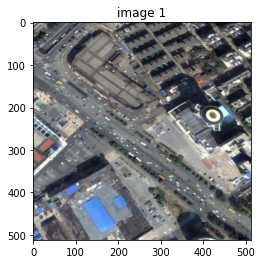

In [ ]:
im1 = plot_to_tensor(test_im1[0,:,:,:],"image 1")

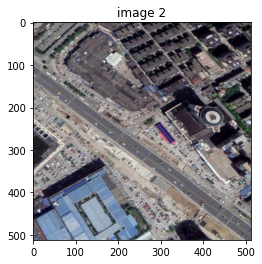

In [ ]:
im2 = plot_to_tensor(test_im2[0,:,:,:],"image 2")

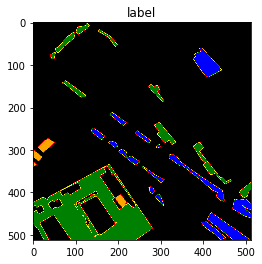

In [ ]:
label = plot_to_tensor(test_label1,"label")

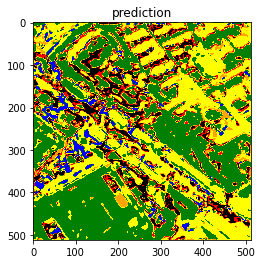

In [ ]:
test_predict = ddn.predict([test_im1,test_im2,test_mask])[0]
test_predict1 = tf.argmax(test_predict[0,:,:,0:6],axis=-1)
prediction = plot_to_tensor(test_predict1,"prediction")

In [ ]:
test_label2= tf.argmax(test_label[0,:,:,6:],axis=-1)

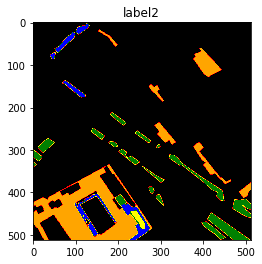

In [ ]:
label2 = plot_to_tensor(test_label2,"label2")

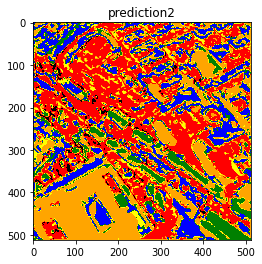

In [ ]:
test_predict2 = tf.argmax(test_predict[0,:,:,6:],axis=-1)
prediction2 = plot_to_tensor(test_predict2,"prediction2")

In [ ]:
%tensorboard --logdir logs/gradient_tape

Reusing TensorBoard on port 6006 (pid 363), started 3:03:35 ago. (Use '!kill 363' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
with train_summary_writer.as_default():
  tf.summary.image("im1",im1, step=0)
  tf.summary.image("im2",im2, step=0)
  tf.summary.image("ground thruth",label, step=0)
  tf.summary.image("prediction",prediction, step=0)

In [ ]:
!tensorboard dev upload \
  --logdir logs/gradient_tape \
  --name "DDN with change mask lr = 5e-4, balenced class weights 5epochs" \
  --description "low Accuracy ~ , mask in supervised layer 1-4 multi layer MSE loss layer weights = [8,4,2,1,1]"  \

2021-03-13 05:14:06.399522: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Upload started and will continue reading any new data as it's added to the logdir.

To stop uploading, press Ctrl-C.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/AN8V00mIQ320nPoqADjupQ/

[2021-03-13T05:14:10] Started scanning logdir.
[2021-03-13T05:14:25] Total uploaded: 14843 scalars, 0 tensors, 0 binary objects
